# Pryngles module: Sampler

In [2]:
from pryngles import *

{'__module__': 'pryngles.consts', '__dict__': <attribute '__dict__' of 'Consts' objects>, '__weakref__': <attribute '__weakref__' of 'Consts' objects>, '__doc__': None, 'rad': 57.29577951308232, 'deg': 0.017453292519943295, 'ppm': 1000000.0, 'ppb': 1000000000.0, 's': 1.0, 'hr': 3600.0, 'day': 86400.0, 'days': 86400.0, 'd': 86400.0, 'yr': 31557600.0, 'yrs': 31557600.0, 'jyr': 31557600.0, 'sidereal_yr': 31558149.7635, 'yr2pi': 5022642.89091303, 'kyr': 31557600000.0, 'myr': 31557600000000.0, 'gyr': 3.15576e+16, 'm': 1.0, 'cm': 0.01, 'km': 1000.0, 'au': 149597870700.0, 'aus': 149597870700.0, 'pc': 3.085677581e+16, 'parsec': 3.085677581e+16, 'kg': 1.0, 'g': 0.001, 'gram': 0.001, 'msun': 1.9884754159665356e+30, 'solarmass': 1.9884754159665356e+30, 'sunmass': 1.9884754159665356e+30, 'msolar': 1.9884754159665356e+30, 'mmercury': 3.301096181046679e+23, 'mvenus': 4.867466257521637e+24, 'mearth': 5.972365261370795e+24, 'mmars': 6.417120205436417e+23, 'mjupiter': 1.8981872396165582e+27, 'msaturn':


----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK

----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK

----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK

----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK

----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK

----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK

----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK

----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK

----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK

----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK

-------------------

## External modules

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

#Plotting in 3d
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, PathPatch
from mpl_toolkits import mplot3d
from scipy.spatial.transform import Rotation
import math

## Constants

In [4]:
""" Sampler presets are the values of N 
    for which there are already stored samples
"""

SAMPLER_SPHERE_PRESETS = np.array(
    list(np.arange(100, 1000, 100))+\
    list(np.arange(1000, 2000, 200))+\
    list(np.arange(2000, 3000, 300))+\
    list(np.arange(3000, 4000, 400))+\
    list(np.arange(4000, 5000, 500))+\
    [5000]
)
SAMPLER_CIRCLE_PRESETS = np.arange(100, 6000, 100)
SAMPLER_PRESETS = ["sphere", "circle", "ring"]

## Sampler class

In [5]:
Sampler_doc = f"""\
    Fibonacci sampling of disks and spheres.
    
    Initialization attributes:
        N: integer:
            Number of points (points).
        
    Optional attibutes:
    
        seed: integer. default = 0:
            Value of the integer seed of random number generation (if 0 no random seed is set).
            If a non-zero seed is used the position of the points for a given geometry will be 
            always the same.
            
        filename: string, default = None:
            Load object from a binary file.  The binary file should be previously prepared with
            the method .save_to of the class.

    Atributes to load data from presets:

        preset: string, default = None:
            If set, we load a preset sample from disk of the type preset.
            Possible values: "sphere", "circle", "ring"
            
        ri: float, default = 0:
            Inner radius of the ring when preset = "ring"
                
    Secondary attributes:
    
        dim: integer. 
            Dimension of sampling.
            
        ss: numpy array (Nx3).
            Position of the points in cartesian coordinates, 
            
        pp: numpy array (Nx3).
            Position of the points in spherical coordinates (r,theta,phi), 
            where theta is azimutal angle (angle with respecto to x-axis) and phi is "elevation" 
            (complement of polar angle).

            Notice that this convention is different than that of regular vectorial calculus
            where spherical coordinates are (r,theta,phi), but theta is the polar angle and phi 
            the azimutal one.
            
        purged: boolean. default = False:
            Is the sample purged?.  Purge is the process by which points too close are
            removed until the average distance between points is similar.
        
        dmin, dmed, dmax: float
            Minimum, median and maximum distance between points.
        
        ds: numpy array (N).
            Distance to the nearest neighbor for all the points.
            
        dran: float.
            Range of distances between points (dmax-dmin).  While the smaller this quantity the better.
            
        dstar: float.
            As measure of distances (sqrt(N)*dmed). Typically this value is between 2.4 and 3.4
            (see source http://extremelearning.com.au/evenly-distributing-points-on-a-sphere)

    Other attributes:
    
        cargs: dictionary.  default = dict(color="k",fill=False,alpha=0.3): 
            Arguments for plotting the circumference in polar.
                   
        wargs: dictionary. default = dict(color="k",lw=0.1): 
            Arguments for plotting a sphere in 3d space.
            
    Notes:
        
        This class and module is based on fibpy by Martin Roberts, source code: 
        https://github.com/matt77hias/fibpy
    
"""

In [6]:
class Sampler(PrynglesCommon):
    def __init__(self,N=1000,seed=0,filename=None,preset=None,ri=0):
        
        #If filename is provided load object from filename
        if filename:
            self.load_from(filename)
            return
        
        #If preset is provided, read preset from file
        if preset:
            if preset not in SAMPLER_PRESETS:
                raise ValueError(f"No presets for {preset} available.  This are the available presets: {SAMPLER_PRESETS}.")
            
            #Modify N if it is a ring
            qring = False
            if preset is "ring":
                N = N / (1-ri**2)
                preset = "circle"
                qring = True
            
            #Calculate the closest Npreset
            exec(f"self.Npreset=SAMPLER_{preset.upper()}_PRESETS[abs({N}-SAMPLER_{preset.upper()}_PRESETS).argmin()]")
            
            Npreset = self.Npreset
            filename = Misc.get_data(f"sampler_presets/sample_{preset}_N_{Npreset}.pkl")
            self.load_from(filename)
            self.Npreset = Npreset
            self.filename = filename
            
            #If the preset is a ring cut a hole
            if qring:
                self._cut_hole(ri) 
            return
        
        #Basic
        self.N = N
        self.seed = seed
        
        #Derivative
        self.dim = 0
        self.ss = None
        self.pp = None
        self.dmin = self.dmed = self.dmax = self.dran = self.dstar = 0
        
        #Purge
        self.purged = False
        
        #Plotting
        self.cargs = dict(color="k", fill=False, alpha=0.1) # 2d plot
        self.wargs = dict(color="k", lw=0.1) # 3d plot
        
        #Random seed
        self._seed_sampler()

    def _get_min_distance(self,r,rs):
        """
        Get the minimum distance from point r to points rs
        
        Parameter:
            r: numpy array (3):
                coordinates of the point.
            rs: numpy array (N)
                coordinates of the points.
        
        Return:
            dmin: float
                minimum distance.
        """
        deltas = rs - r
        dist = np.einsum('ij,ij->i', deltas, deltas)
        imin = np.argsort(dist)[1]
        return np.sqrt(dist[imin])

    def _calc_distances(self):
        """
        Calculate the minimum distances of all points in the sample.
        
        Update:
            ds,dmin,dmax,dmed,dran,dstar.
        """
        self.ds = np.array([self._get_min_distance(self.ss[i],self.ss) for i in range(len(self.ss))])
        self.dmin = self.ds.min()
        self.dmax = self.ds.max()
        self.dmed = np.median(self.ds)
        self.dran = self.dmax-self.dmin
        self.dstar = np.sqrt(self.N)*self.dmed
        
        #Area of each spangle
        self.aes = self.A/self.N

        #Effective diameter
        self.deff = 2*(self.aes/np.pi)**0.5

    def _seed_sampler(self):
        if self.seed:
            np.random.seed(self.seed)
            
Sampler.__doc__ = Sampler_doc

In [7]:
def plot(self, spangled=dict(), **args):
    """
    Plot sample.

    Parameters:
        args: scatter plotting options, dictionary.
    """
    sargs= dict(c='k', s=1.5)
    sargs.update(args)
    
    #Spangles options
    if spangled:
        defaults = dict(alpha=0.3)
        defaults.update(spangled)
    
    if self.dim == 2:            
        self.fig,self.ax = plt.subplots()
        self.ax.scatter(self.ss[:,0], self.ss[:,1], **sargs)
        self.ax.add_patch( plt.Circle((0,0), 1, **self.cargs))
        self.ax.set_aspect("equal")
        if spangled:
            for isp in range(self.N):
                c = Circle(self.ss[isp], self.deff/2, **defaults)
                self.ax.add_patch(c)
                
    else:
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111, projection='3d')
        self.ax.scatter(self.ss[:,0], self.ss[:,1], self.ss[:,2], **sargs)
        u,v = np.mgrid[0:2*np.pi:20j,0:np.pi:10j]
        x = np.cos(u)*np.sin(v)
        y = np.sin(u)*np.sin(v)
        z = np.cos(v)
        self.ax.plot_wireframe(x, y, z, **self.wargs)
        
        if spangled:
            for isp in range(self.N):
                Plot.circle3d(self.ax, self.ss[isp], self.deff/2, zDir=self.ss[isp], **defaults)
        
        self.ax.set_box_aspect([1 ,1 , 1])
        
    self.fig.tight_layout()

Sampler.plot = plot

In [8]:
def gen_circle(self, perturbation=1, boundary=2):
    """ Sample points in fibonacci spiral on the unit circle

    Optional parameters:

        perturbation: type of perturbation (0 normal perturbation, 1 random perturbation), int

        boundary: type of boundary (0 jagged, >1 smooth)

    Update:
        ss, pp
    """
    self._seed_sampler()
    
    #Unitary radius
    self.R = 1

    #Total area
    self.A = np.pi*self.R**2
        
    shift = 1.0 if perturbation == 0 else self.N*np.random.random()

    ga = np.pi * (3.0-np.sqrt(5.0))

    # Boundary points
    np_boundary = round(boundary*np.sqrt(self.N))

    self.dim = 2
    self.ss = np.zeros((self.N,3))
    self.pp = np.zeros((self.N,3))
    j = 0
    for i in range(self.N):
        if i > self.N - (np_boundary+1):
            r = 1.0
        else:
            r = np.sqrt((i+0.5) / (self.N - 0.5 * (np_boundary+1)))
        phi   = ga * (i+shift)
        self.ss[j,:] = np.array([r*np.cos(phi), r*np.sin(phi), 0])
        self.pp[j,:] = np.array([r, np.mod(phi, 2*np.pi), 0])
        j += 1

    #Distances
    self._calc_distances()
    
Sampler.gen_circle = gen_circle

<IPython.core.display.Javascript object>


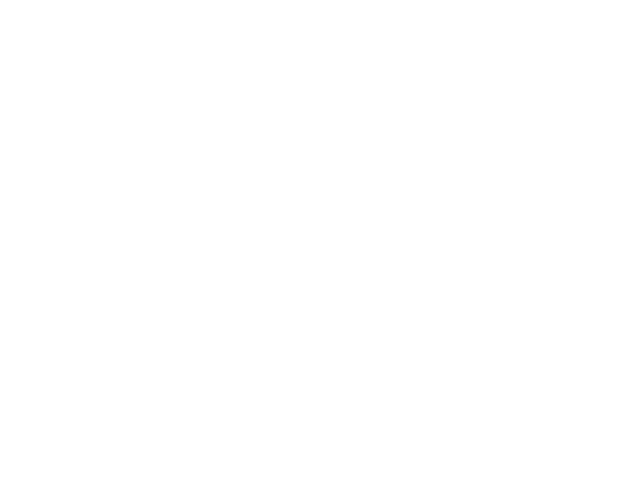

<IPython.core.display.Javascript object>


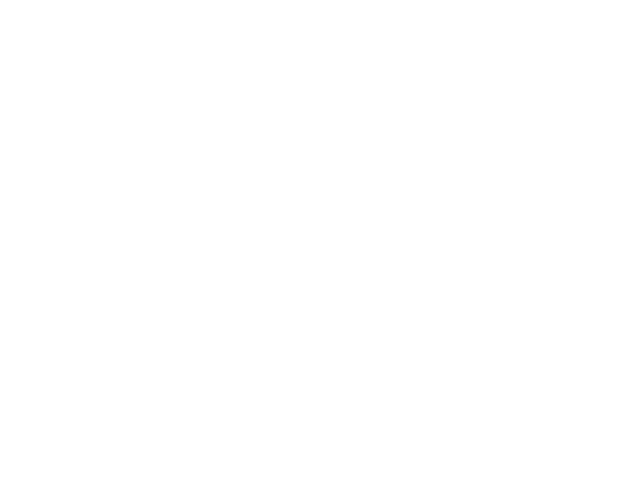

.
----------------------------------------------------------------------
Ran 1 test in 0.542s

OK


In [9]:
if IN_JUPYTER:
    %matplotlib nbagg
    def test_circle(self):

        #Generate circle
        S = Sampler(1000, seed=10)
        S.gen_circle()
        S.plot()
        S.plot(c='b', spangled=dict(color='r'))
        S.ax.set_title(f"N = {S.N}, dmed = {S.dmed:.4f}, deff = {S.deff:.4f}", fontsize=10)
        S.fig.tight_layout()
        
    class Test(unittest.TestCase):pass    
    Test.test_circle = test_circle
    unittest.main(argv=['first-arg-is-ignored'],  exit=False)

In [10]:
def _cut_hole(self, ri=0):
    """
    Cut a hole in the data (this applies to circle sampling)
    """
    #Purge points
    cond =~ ((self.pp[:,1]>0) & (self.pp[:,0]<=ri))
    self.pp = self.pp[cond]
    self.ss = self.ss[cond]
    self.N = len(self.pp)
    
    #Correct area
    self.A = self.A - np.pi*ri**2
    
    #Distances
    self._calc_distances()
    
Sampler._cut_hole = _cut_hole

<IPython.core.display.Javascript object>


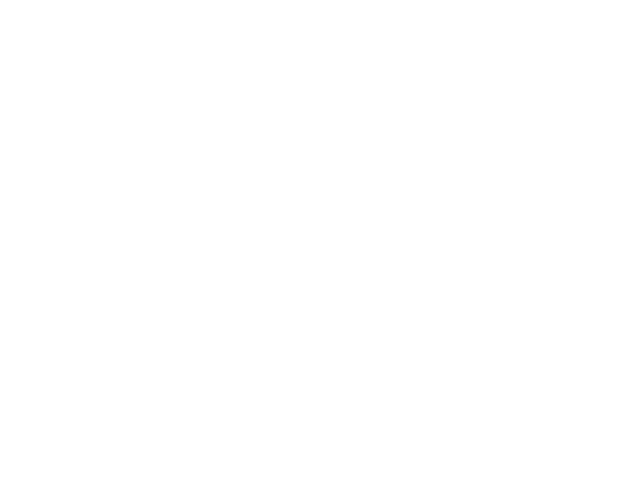

<IPython.core.display.Javascript object>


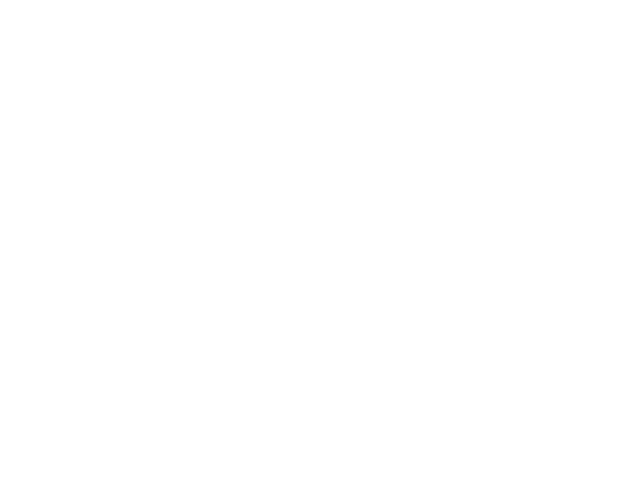

.
----------------------------------------------------------------------
Ran 1 test in 0.460s

OK


In [11]:
if IN_JUPYTER:
    %matplotlib nbagg
    def test_cut(self):

        #Generate circle
        S = Sampler(1000, seed=10)
        S.gen_circle()
        S._cut_hole(0.5)
        S.plot()
        S.plot(c='b',spangled=dict(color='r'))
        S.ax.set_title(f"N = {S.N}, dmed = {S.dmed:.4f}, deff = {S.deff:.4f}", fontsize=10)
        S.fig.tight_layout()
        
    class Test(unittest.TestCase):pass    
    Test.test_cut = test_cut
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

In [12]:
def gen_ring(self, ri=0.5, perturbation=1, boundary=2):
    """ Sample points in fibonacci spiral on the unit circle, but including an inner gap (as in ring)

    Parameters:
        fi: float, default = 0.5:
            Inner radius of the ring.

    Optional parameters:
        perturbation: type of perturbation (0 normal perturbation, 1 random perturbation), int
        boundary: type of boundary (0 jagged, >1 smooth)

    Example:
        s.Sample(1000)
        s.gen_fullring(0.3)

    Update:
        ss, pp
    """
    if self.N < 100:
        raise ValueError(f"The number of points for a ring shouldn't be lower than 100.  You provided {self.N}")

    #Compute effective number
    self.N = int(self.N / (1-ri**2))
    self.gen_circle(perturbation,boundary)
    
    #Cut hole
    self._cut_hole(ri)
        
Sampler.gen_ring = gen_ring

0.003942390780975427
2.0106192982974678
2.0106192982974678
2.010619298297468


<IPython.core.display.Javascript object>


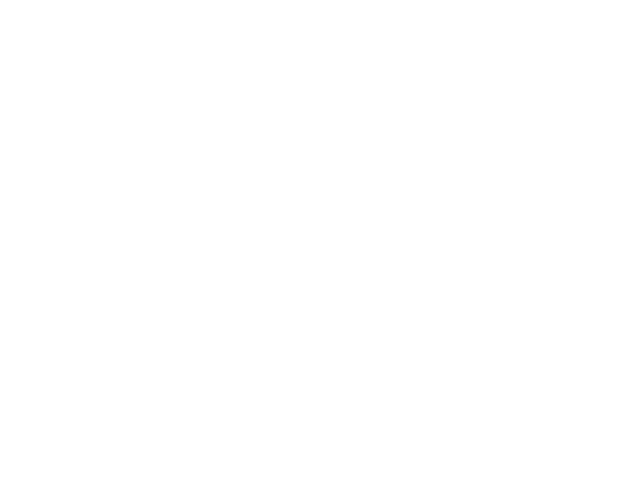

<IPython.core.display.Javascript object>


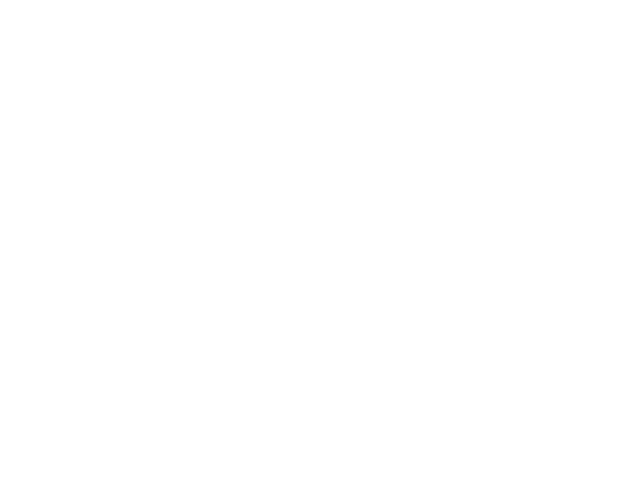

.
----------------------------------------------------------------------
Ran 1 test in 0.390s

OK


In [13]:
if IN_JUPYTER:
    %matplotlib nbagg
    def test_ring(self):

        #Generate rings
        S = Sampler(500,seed=10)
        fi = 0.6
        S.gen_ring(fi)
        print(S.aes)
            
        #Test area
        print(S.A)
        print(np.pi * (1-fi**2))
        print(np.pi * (S.deff/2)**2*S.N)
    
        S.plot()
        S.plot(spangled = dict(color='r'))
        S.ax.set_title(f"N = {S.N}, dmed = {S.dmed:.4f}, deff = {S.deff:.4f}",fontsize = 10)
        S.fig.tight_layout()

    class Test(unittest.TestCase):pass    
    Test.test_ring = test_ring
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

In [14]:
def gen_sphere(self, perturbation=1):
    """ Sample points in the unit sphere following fibonacci spiral

    Optional parameters:
        perturbation: type of perturbation (0 normal perturbation, 1 random perturbation), int

    Update:
        ss, pp
    """
    self._seed_sampler()

    #Unitary radius
    self.R = 1

    #Total area of the Sample
    self.A = 4*np.pi*self.R**2

    shift = 1.0 if perturbation == 0 else self.N*np.random.random()

    ga = np.pi * (3.0-np.sqrt(5.0))
    offset = 2.0/self.N

    self.dim = 3
    self.ss = np.zeros((self.N,self.dim))
    self.pp = np.zeros((self.N,self.dim))
    j = 0
    for i in range(self.N):
        phi   = ga * ((i+shift) % self.N)
        cos_phi = np.cos(phi)
        sin_phi = np.sin(phi)
        cos_theta = ((i+0.5) * offset) - 1.0
        sin_theta = np.sqrt(1.0 - cos_theta*cos_theta)
        theta = np.arccos(cos_theta)            
        self.ss[j,:] = np.array([cos_phi*sin_theta, sin_phi*sin_theta, cos_theta])
        self.pp[j,:] = np.array([1, np.mod(phi,2*np.pi), np.pi/2 - theta])
        j += 1

    #Distances
    self._calc_distances()

Sampler.gen_sphere = gen_sphere

<IPython.core.display.Javascript object>


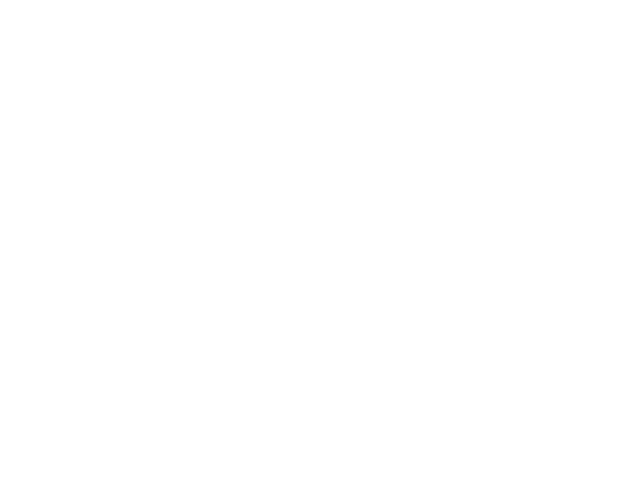

<IPython.core.display.Javascript object>


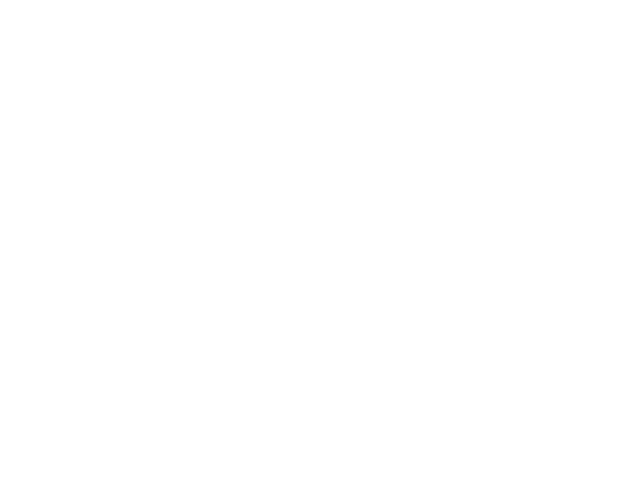

.
----------------------------------------------------------------------
Ran 1 test in 0.128s

OK


In [15]:
if IN_JUPYTER:
    %matplotlib nbagg
    def test_sphere(self):
        
        #Generate sphere
        S = Sampler(100, seed=10)
        S.gen_sphere()
        S.plot()
        S.plot(spangled=dict(color='r'))
        S.ax.set_title(f"N = {S.N}, dmed = {S.dmed:.4f}, deff = {S.deff:.4f}", fontsize=10)
        S.fig.tight_layout()
        
    class Test(unittest.TestCase):pass    
    Test.test_sphere = test_sphere
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

In [16]:
def purge_sample(self, tol=0.5):
    """
    Purge sample, ie. remove points close than a given threshold.

    Optional parameters:
        tol: distance to purge, ie. if dmin<tol*dmed then purge, float

    Update:
        ss, pp, N, _purge
    """
    if self.purged:
        print("Already purged.")
        return 0

    self.purged = False
    purge = True
    while purge:
        self._calc_distances()
        if self.dmin < tol*self.dmed:
            ipurge = np.argsort(self.ds)[0]
            self.ss = np.delete(self.ss,ipurge,0)
            self.pp = np.delete(self.pp,ipurge,0)
            self.N -= 1
            self.purged = True
            purge = True
        else:
            purge = False

Sampler.purge_sample = purge_sample

<IPython.core.display.Javascript object>


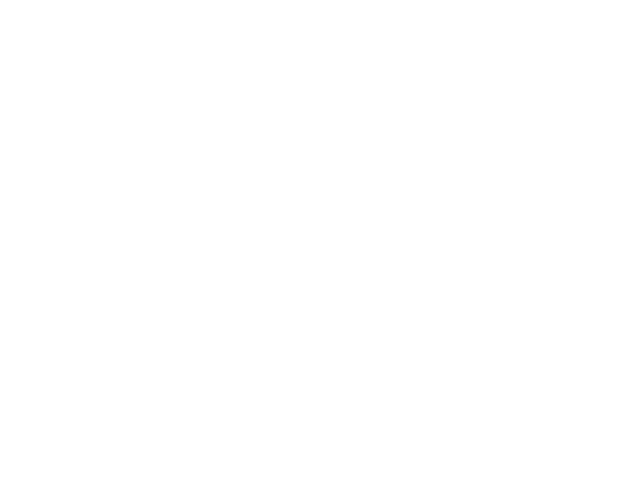

.
----------------------------------------------------------------------
Ran 1 test in 0.940s

OK


In [17]:
if IN_JUPYTER:
    %matplotlib nbagg
    def test_purge(self):
        
        #Generate sphere
        S=Sampler(1000, seed=10)
        S.gen_sphere()
        S.purge_sample()
        S.plot()
        S.ax.set_title(f"N = {S.N}, dmed = {S.dmed:.4f}, deff = {S.deff:.4f}", fontsize=10)
        S.fig.tight_layout()
        
    class Test(unittest.TestCase):pass    
    Test.test_purge = test_purge
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

## Test presets

In [18]:
if IN_JUPYTER:
    %matplotlib nbagg
    def test_pre(self):
        sp=Sampler(preset="sphere", N=2750)
        print(sp.Npreset,sp.N)
        sp.plot(spangled=dict(color='b', alpha=0.1))
        
        sp=Sampler(preset="circle", N=850)
        print(sp.Npreset, sp.N)
        sp.plot(spangled=dict(color='b', alpha=0.1))
        
        sp=Sampler(preset="ring", N=1150, ri=0.5)
        print(sp.Npreset, sp.N)
        sp.plot(spangled=dict(color='b', alpha=0.1))
    
    class Test(unittest.TestCase):pass    
    Test.test_pre = test_pre
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

2600 2584


<IPython.core.display.Javascript object>

800 800


<IPython.core.display.Javascript object>

1500 1135


<IPython.core.display.Javascript object>

.
----------------------------------------------------------------------
Ran 1 test in 1.709s

OK


--End--

## Sampler presets

Each time the Sampler class is modified you should regenerate the sample presets.

Sphere presets:

In [19]:
#"""
from tqdm import tqdm
for N in tqdm(SAMPLER_SPHERE_PRESETS):
    sp = Sampler(N=N)
    sp.gen_sphere()
    sp.purge_sample()
    sp.save_to(Misc.get_data(f"sampler_presets/sample_sphere_N_{N}.pkl"))
#""";

100%|██████████| 24/24 [00:54<00:00,  2.27s/it]


Circle presets:

In [ ]:
#"""
from tqdm import tqdm
for N in tqdm(SAMPLER_CIRCLE_PRESETS):
    sp = Sampler(N=N)
    sp.gen_circle()
    sp.save_to(Misc.get_data(f"sampler_presets/sample_circle_N_{N}.pkl"))
#""";

 88%|████████▊ | 52/59 [00:32<00:11,  1.65s/it]

Done!